**PART #0 - IMPORTING NECESSARY DEPENDENCIES**


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, timezone
import requests
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Set the style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

**PART #1 - DATA LOADING**


In [ ]:
def load_data(file_path='../dataset/global_air_pollution_data.csv'):
    """
    Load the global air pollution dataset
    
    Parameters:
    file_path (str): Path to the dataset file
    
    Returns:
    pandas.DataFrame: DataFrame containing the loaded data
    """
    print(f"Loading global air pollution data from {file_path}...")
    
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded data with {df.shape[0]} rows and {df.shape[1]} columns")
        return df
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        # Create sample data for testing if file is not available
        print("Creating sample data for testing...")
        countries = ['US', 'IN', 'CN', 'GB', 'FR', 'DE', 'IT', 'ES', 'BR', 'JP']
        cities = ['New York', 'Delhi', 'Beijing', 'London', 'Paris', 'Berlin', 'Rome', 'Madrid', 'Sao Paulo', 'Tokyo']
        
        np.random.seed(42)
        n_samples = 300
        
        sample_data = {
            'country_name': np.random.choice(countries, n_samples),
            'city_name': np.random.choice(cities, n_samples),
            'aqi_value': np.random.randint(10, 300, n_samples),
            'aqi_category': np.random.choice(['Good', 'Moderate', 'Unhealthy', 'Very Unhealthy', 'Hazardous'], n_samples),
            'co_aqi_value': np.random.randint(10, 200, n_samples),
            'co_aqi_category': np.random.choice(['Good', 'Moderate', 'Unhealthy'], n_samples),
            'ozone_aqi_value': np.random.randint(10, 150, n_samples),
            'ozone_aqi_category': np.random.choice(['Good', 'Moderate', 'Unhealthy'], n_samples),
            'no2_aqi_value': np.random.randint(10, 180, n_samples),
            'no2_aqi_category': np.random.choice(['Good', 'Moderate', 'Unhealthy'], n_samples),
            'pm2.5_aqi_value': np.random.randint(10, 250, n_samples),
            'pm2.5_aqi_category': np.random.choice(['Good', 'Moderate', 'Unhealthy', 'Very Unhealthy'], n_samples)
        }
        
        df = pd.DataFrame(sample_data)
        print(f"Created sample data with {df.shape[0]} rows")
        return df

In [72]:
def perform_eda(df):
    """
    Perform Exploratory Data Analysis on the dataset
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    
    Returns:
    pandas.DataFrame: Processed DataFrame ready for analysis
    """
    print("\n--- EXPLORATORY DATA ANALYSIS ---")
    
    # Basic information
    print(f"Dataset shape: {df.shape}")
    print("\nData types:")
    print(df.dtypes)
    
    # Check for missing values
    print("\nMissing values:")
    print(df.isnull().sum())
    
    # Summary statistics for numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print("\nSummary statistics for numerical columns:")
    print(df[numeric_cols].describe())
    
    # Distribution of AQI categories
    plt.figure(figsize=(12, 6))
    sns.countplot(y='aqi_category', data=df, order=df['aqi_category'].value_counts().index)
    plt.title('Distribution of AQI Categories')
    plt.xlabel('Count')
    plt.ylabel('AQI Category')
    plt.tight_layout()
    plt.savefig('aqi_category_distribution.png')
    
    # Distribution of AQI values
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    sns.histplot(df['aqi_value'], kde=True)
    plt.title('Overall AQI Distribution')
    
    plt.subplot(2, 2, 2)
    sns.histplot(df['co_aqi_value'], kde=True, color='orange')
    plt.title('CO AQI Distribution')
    
    plt.subplot(2, 2, 3)
    sns.histplot(df['ozone_aqi_value'], kde=True, color='green')
    plt.title('Ozone AQI Distribution')
    
    plt.subplot(2, 2, 4)
    sns.histplot(df['pm2.5_aqi_value'], kde=True, color='red')
    plt.title('PM2.5 AQI Distribution')
    
    plt.tight_layout()
    plt.savefig('aqi_distributions.png')
    
    # Correlation between pollutants
    aqi_cols = [col for col in df.columns if 'aqi_value' in col]
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[aqi_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Between Pollutant AQI Values')
    plt.tight_layout()
    plt.savefig('pollutant_correlation.png')
    
    # Average AQI values by country (top 15)
    plt.figure(figsize=(12, 8))
    country_aqi = df.groupby('country_name')['aqi_value'].mean().sort_values(ascending=False).head(15)
    sns.barplot(x=country_aqi.values, y=country_aqi.index)
    plt.title('Countries with Highest Average AQI Values')
    plt.xlabel('Average AQI Value')
    plt.ylabel('Country')
    plt.tight_layout()
    plt.savefig('country_aqi_comparison.png')
    
    # Average AQI values by city (top 15)
    plt.figure(figsize=(12, 8))
    city_aqi = df.groupby('city_name')['aqi_value'].mean().sort_values(ascending=False).head(15)
    sns.barplot(x=city_aqi.values, y=city_aqi.index)
    plt.title('Cities with Highest Average AQI Values')
    plt.xlabel('Average AQI Value')
    plt.ylabel('City')
    plt.tight_layout()
    plt.savefig('city_aqi_comparison.png')
    
    # Pairplot of numerical features
    plt.figure(figsize=(16, 12))
    sns.pairplot(df[aqi_cols], diag_kind='kde')
    plt.suptitle('Pairwise Relationships Between AQI Values', y=1.02)
    plt.savefig('aqi_pairplot.png')
    
    return df

**PART #0 - IMPORTING NECESSARY DEPENDENCIES**


In [73]:
def preprocess_data(df):
    """
    Preprocess the data for clustering
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    
    Returns:
    tuple: (features_df, scaled_features) - Original feature DataFrame and scaled features
    """
    print("\n--- DATA PREPROCESSING ---")
    
    # Select numerical features for clustering
    feature_cols = ['aqi_value', 'co_aqi_value', 'ozone_aqi_value', 'no2_aqi_value', 'pm2.5_aqi_value']
    
    print(f"Selected features for clustering: {feature_cols}")
    
    # Create features DataFrame
    features_df = df[feature_cols].copy()
    
    # Handle missing values
    missing_count = features_df.isnull().sum().sum()
    if missing_count > 0:
        print(f"Handling {missing_count} missing values")
        features_df = features_df.fillna(features_df.mean())
    
    # Check for outliers
    print("\nChecking for outliers:")
    for col in features_df.columns:
        Q1 = features_df[col].quantile(0.25)
        Q3 = features_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((features_df[col] < lower_bound) | (features_df[col] > upper_bound)).sum()
        outlier_percentage = (outliers / len(features_df)) * 100
        print(f"  {col}: {outliers} outliers ({outlier_percentage:.2f}%)")
        
        # Cap outliers
        if outlier_percentage > 5:
            print(f"  Capping outliers for {col}")
            features_df[col] = features_df[col].clip(lower_bound, upper_bound)
    
    # Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)
    
    # Dimensionality reduction for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    
    # Plot PCA results
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    plt.title('PCA of Air Quality Data')
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.tight_layout()
    plt.savefig('pca_visualization.png')
    
    return features_df, scaled_features

**PART #0 - IMPORTING NECESSARY DEPENDENCIES**


In [74]:
def apply_kmeans(features, max_clusters=10):
    """
    Apply K-means clustering
    
    Parameters:
    features (numpy.ndarray): Scaled features for clustering
    max_clusters (int): Maximum number of clusters to try
    
    Returns:
    tuple: (best_kmeans, scores) - Best model and performance scores
    """
    print("\n--- K-MEANS CLUSTERING ---")
    
    # Find optimal number of clusters using the Elbow method
    inertia_values = []
    silhouette_values = []
    db_values = []
    ch_values = []
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(features)
        
        # Calculate performance metrics
        inertia_values.append(kmeans.inertia_)
        if k > 1:  # Silhouette score requires at least 2 clusters
            silhouette_values.append(silhouette_score(features, kmeans.labels_))
            db_values.append(davies_bouldin_score(features, kmeans.labels_))
            ch_values.append(calinski_harabasz_score(features, kmeans.labels_))
    
    # Plot Elbow method
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(range(2, max_clusters + 1), inertia_values, 'bo-')
    plt.title('Elbow Method for K-means')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    
    plt.subplot(2, 2, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_values, 'go-')
    plt.title('Silhouette Score for K-means')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    
    plt.subplot(2, 2, 3)
    plt.plot(range(2, max_clusters + 1), db_values, 'ro-')
    plt.title('Davies-Bouldin Score for K-means')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Score')
    
    plt.subplot(2, 2, 4)
    plt.plot(range(2, max_clusters + 1), ch_values, 'mo-')
    plt.title('Calinski-Harabasz Score for K-means')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Calinski-Harabasz Score')
    
    plt.tight_layout()
    plt.savefig('kmeans_evaluation.png')
    
    # Find optimal k based on silhouette score
    optimal_k = silhouette_values.index(max(silhouette_values)) + 2
    print(f"Optimal number of clusters for K-means: {optimal_k}")
    
    # Train final K-means model with optimal k
    best_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    best_kmeans.fit(features)
    
    # Calculate final scores
    scores = {
        'algorithm': 'K-means',
        'n_clusters': optimal_k,
        'inertia': best_kmeans.inertia_,
        'silhouette': silhouette_score(features, best_kmeans.labels_),
        'davies_bouldin': davies_bouldin_score(features, best_kmeans.labels_),
        'calinski_harabasz': calinski_harabasz_score(features, best_kmeans.labels_)
    }
    
    print(f"K-means performance metrics:")
    for metric, value in scores.items():
        if metric != 'algorithm':
            print(f"  {metric}: {value}")
    
    return best_kmeans, scores

def apply_hierarchical_clustering(features, max_clusters=10):
    """
    Apply Hierarchical (Agglomerative) clustering
    
    Parameters:
    features (numpy.ndarray): Scaled features for clustering
    max_clusters (int): Maximum number of clusters to try
    
    Returns:
    tuple: (best_model, scores) - Best model and performance scores
    """
    print("\n--- HIERARCHICAL CLUSTERING ---")
    
    # Create linkage matrix for dendrogram
    linkage_matrix = linkage(features, method='ward')
    
    # Plot dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, truncate_mode='level', p=5)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.savefig('hierarchical_dendrogram.png')
    
    # Evaluate different numbers of clusters
    silhouette_values = []
    db_values = []
    ch_values = []
    
    for k in range(2, max_clusters + 1):
        model = AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(features)
        
        # Calculate performance metrics
        silhouette_values.append(silhouette_score(features, labels))
        db_values.append(davies_bouldin_score(features, labels))
        ch_values.append(calinski_harabasz_score(features, labels))
    
    # Plot evaluation metrics
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(range(2, max_clusters + 1), silhouette_values, 'go-')
    plt.title('Silhouette Score for Hierarchical Clustering')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    
    plt.subplot(2, 2, 2)
    plt.plot(range(2, max_clusters + 1), db_values, 'ro-')
    plt.title('Davies-Bouldin Score for Hierarchical Clustering')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Score')
    
    plt.subplot(2, 2, 3)
    plt.plot(range(2, max_clusters + 1), ch_values, 'mo-')
    plt.title('Calinski-Harabasz Score for Hierarchical Clustering')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Calinski-Harabasz Score')
    
    plt.tight_layout()
    plt.savefig('hierarchical_evaluation.png')
    
    # Find optimal k based on silhouette score
    optimal_k = silhouette_values.index(max(silhouette_values)) + 2
    print(f"Optimal number of clusters for Hierarchical Clustering: {optimal_k}")
    
    # Train final model with optimal k
    best_model = AgglomerativeClustering(n_clusters=optimal_k)
    labels = best_model.fit_predict(features)
    
    # Calculate final scores
    scores = {
        'algorithm': 'Hierarchical',
        'n_clusters': optimal_k,
        'silhouette': silhouette_score(features, labels),
        'davies_bouldin': davies_bouldin_score(features, labels),
        'calinski_harabasz': calinski_harabasz_score(features, labels)
    }
    
    print(f"Hierarchical clustering performance metrics:")
    for metric, value in scores.items():
        if metric != 'algorithm':
            print(f"  {metric}: {value}")
    
    return best_model, scores

def apply_dbscan(features):
    """
    Apply DBSCAN clustering
    
    Parameters:
    features (numpy.ndarray): Scaled features for clustering
    
    Returns:
    tuple: (best_model, scores) - Best model and performance scores
    """
    print("\n--- DBSCAN CLUSTERING ---")
    
    # Determine optimal epsilon using k-distance graph
    from sklearn.neighbors import NearestNeighbors
    
    neighbors = NearestNeighbors(n_neighbors=5)
    neighbors_fit = neighbors.fit(features)
    distances, indices = neighbors_fit.kneighbors(features)
    
    # Get the distances to the 5th nearest neighbor
    distances = np.sort(distances[:, 4])
    
    # Plot k-distance graph
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title('K-distance Graph for DBSCAN')
    plt.xlabel('Points sorted by distance')
    plt.ylabel('Distance to 5th nearest neighbor')
    plt.tight_layout()
    plt.savefig('dbscan_kdistance.png')
    
    # Find the optimal epsilon value at the "elbow" point
    # For simplicity, we'll try different values and pick based on performance
    eps_values = np.linspace(0.1, 2.0, 10)
    min_samples_values = [3, 5, 10]
    
    best_silhouette = -1
    best_eps = 0.5
    best_min_samples = 5
    best_labels = None
    
    results = []
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(features)
            
            # Check if we have a reasonable number of clusters (excluding noise)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            if n_clusters >= 2:  # We need at least 2 clusters for silhouette score
                # Calculate performance metrics
                try:
                    # Filter out noise points for silhouette score
                    if n_noise > 0:
                        mask = labels != -1
                        silhouette = silhouette_score(features[mask], labels[mask])
                    else:
                        silhouette = silhouette_score(features, labels)
                        
                    # Store results
                    results.append({
                        'eps': eps,
                        'min_samples': min_samples,
                        'n_clusters': n_clusters,
                        'n_noise': n_noise,
                        'silhouette': silhouette
                    })
                    
                    # Update best parameters
                    if silhouette > best_silhouette:
                        best_silhouette = silhouette
                        best_eps = eps
                        best_min_samples = min_samples
                        best_labels = labels
                        
                except Exception as e:
                    # This can happen if there's only one cluster after removing noise
                    print(f"Error calculating metrics for eps={eps}, min_samples={min_samples}: {str(e)}")
    
    # Print results table
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        print("\nDBSCAN parameter search results:")
        print(results_df.sort_values('silhouette', ascending=False).head(5))
        print(f"\nBest parameters: eps={best_eps}, min_samples={best_min_samples}")
        print(f"Number of clusters: {len(set(best_labels)) - (1 if -1 in best_labels else 0)}")
        print(f"Number of noise points: {list(best_labels).count(-1)}")
    else:
        print("Could not find suitable parameters for DBSCAN.")
        best_eps = 0.5
        best_min_samples = 5
    
    # Train final DBSCAN model with best parameters
    best_model = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    labels = best_model.fit_predict(features)
    
    # Calculate final scores
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    # For silhouette score, we need to exclude noise points
    if -1 in labels:
        mask = labels != -1
        if sum(mask) > n_clusters:  # Need more points than clusters
            try:
                silhouette = silhouette_score(features[mask], labels[mask])
                db_score = davies_bouldin_score(features[mask], labels[mask])
                ch_score = calinski_harabasz_score(features[mask], labels[mask])
            except:
                silhouette = np.nan
                db_score = np.nan
                ch_score = np.nan
        else:
            silhouette = np.nan
            db_score = np.nan
            ch_score = np.nan
    else:
        silhouette = silhouette_score(features, labels)
        db_score = davies_bouldin_score(features, labels)
        ch_score = calinski_harabasz_score(features, labels)
    
    scores = {
        'algorithm': 'DBSCAN',
        'eps': best_eps,
        'min_samples': best_min_samples,
        'n_clusters': n_clusters,
        'n_noise': list(labels).count(-1),
        'silhouette': silhouette,
        'davies_bouldin': db_score,
        'calinski_harabasz': ch_score
    }
    
    print(f"DBSCAN performance metrics:")
    for metric, value in scores.items():
        if metric not in ['algorithm', 'eps', 'min_samples']:
            print(f"  {metric}: {value}")
    
    return best_model, scores


**PART #0 - IMPORTING NECESSARY DEPENDENCIES**

In [76]:
def compare_clustering_methods(features_df, scaled_features, kmeans_results, hierarchical_results, dbscan_results, original_df):
    """
    Compare the performance of different clustering methods
    
    Parameters:
    features_df (pandas.DataFrame): Original features DataFrame
    scaled_features (numpy.ndarray): Scaled features used for clustering
    kmeans_results (tuple): (model, scores) for K-means
    hierarchical_results (tuple): (model, scores) for Hierarchical clustering
    dbscan_results (tuple): (model, scores) for DBSCAN
    original_df (pandas.DataFrame): Original dataset with all columns
    """
    print("\n--- CLUSTERING METHODS COMPARISON ---")
    
    # Extract models and scores
    kmeans_model, kmeans_scores = kmeans_results
    hierarchical_model, hierarchical_scores = hierarchical_results
    dbscan_model, dbscan_scores = dbscan_results
    
    # Get cluster labels from each method
    kmeans_labels = kmeans_model.labels_
    hierarchical_labels = hierarchical_model.fit_predict(scaled_features)
    dbscan_labels = dbscan_model.fit_predict(scaled_features)
    
    # Add cluster labels to the original features
    features_df['kmeans_cluster'] = kmeans_labels
    features_df['hierarchical_cluster'] = hierarchical_labels
    features_df['dbscan_cluster'] = dbscan_labels
    
    # Create comparison table
    comparison_data = {
        'Algorithm': ['K-means', 'Hierarchical', 'DBSCAN'],
        'Number of Clusters': [
            kmeans_scores['n_clusters'],
            hierarchical_scores['n_clusters'],
            dbscan_scores['n_clusters']
        ],
        'Silhouette Score': [
            kmeans_scores['silhouette'],
            hierarchical_scores['silhouette'],
            dbscan_scores['silhouette']
        ],
        'Davies-Bouldin Score': [
            kmeans_scores.get('davies_bouldin', np.nan),
            hierarchical_scores.get('davies_bouldin', np.nan),
            dbscan_scores.get('davies_bouldin', np.nan)
        ],
        'Calinski-Harabasz Score': [
            kmeans_scores.get('calinski_harabasz', np.nan),
            hierarchical_scores.get('calinski_harabasz', np.nan),
            dbscan_scores.get('calinski_harabasz', np.nan)
        ]
    }
    
    if 'n_noise' in dbscan_scores:
        comparison_data['Noise Points'] = [0, 0, dbscan_scores['n_noise']]
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\nPerformance comparison:")
    print(comparison_df)
    
    # Visualize clustering results with PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)
    
    plt.figure(figsize=(18, 6))
    
    # K-means
    plt.subplot(1, 3, 1)
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Cluster')
    plt.title(f'K-means Clustering\n(k={kmeans_scores["n_clusters"]}, Silhouette={kmeans_scores["silhouette"]:.3f})')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    
    # Hierarchical
    plt.subplot(1, 3, 2)
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=hierarchical_labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Cluster')
    plt.title(f'Hierarchical Clustering\n(k={hierarchical_scores["n_clusters"]}, Silhouette={hierarchical_scores["silhouette"]:.3f})')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    
    # DBSCAN
    plt.subplot(1, 3, 3)
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Cluster')
    plt.title(f'DBSCAN Clustering\n(eps={dbscan_scores["eps"]}, min_samples={dbscan_scores["min_samples"]}, Silhouette={dbscan_scores["silhouette"]:.3f})')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    
    plt.tight_layout()
    plt.savefig('clustering_comparison.png')
    
    # Add cluster labels to original data for analysis
    df_with_clusters = original_df.copy()
    df_with_clusters['kmeans_cluster'] = kmeans_labels
    df_with_clusters['hierarchical_cluster'] = hierarchical_labels
    df_with_clusters['dbscan_cluster'] = dbscan_labels
    
    # Analyze clusters - K-means
    print("\nK-means Cluster Analysis:")
    kmeans_cluster_profiles = df_with_clusters.groupby('kmeans_cluster').agg({
        'aqi_value': 'mean',
        'co_aqi_value': 'mean',
        'ozone_aqi_value': 'mean',
        'no2_aqi_value': 'mean',
        'pm2.5_aqi_value': 'mean'
    }).round(2)
    
    print(kmeans_cluster_profiles)
    
    # Visualize K-means cluster profiles
    plt.figure(figsize=(14, 8))
    kmeans_cluster_profiles.plot(kind='bar', figsize=(14, 8))
    plt.title('K-means Cluster Profiles')
    plt.xlabel('Cluster')
    plt.ylabel('Mean AQI Value')
    plt.legend(title='Pollutant')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig('kmeans_cluster_profiles.png')
    
    # Analyze clusters - Hierarchical
    print("\nHierarchical Cluster Analysis:")
    hierarchical_cluster_profiles = df_with_clusters.groupby('hierarchical_cluster').agg({
        'aqi_value': 'mean',
        'co_aqi_value': 'mean',
        'ozone_aqi_value': 'mean',
        'no2_aqi_value': 'mean',
        'pm2.5_aqi_value': 'mean'
    }).round(2)
    
    print(hierarchical_cluster_profiles)
    
    # Visualize Hierarchical cluster profiles
    plt.figure(figsize=(14, 8))
    hierarchical_cluster_profiles.plot(kind='bar', figsize=(14, 8))
    plt.title('Hierarchical Cluster Profiles')
    plt.xlabel('Cluster')
    plt.ylabel('Mean AQI Value')
    plt.legend(title='Pollutant')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig('hierarchical_cluster_profiles.png')
    
    # Analyze clusters - DBSCAN (excluding noise points)
    print("\nDBSCAN Cluster Analysis:")
    # Filter out noise points (-1 cluster)
    dbscan_df = df_with_clusters[df_with_clusters['dbscan_cluster'] != -1]
    
    if len(dbscan_df) > 0:
        dbscan_cluster_profiles = dbscan_df.groupby('dbscan_cluster').agg({
            'aqi_value': 'mean',
            'co_aqi_value': 'mean',
            'ozone_aqi_value': 'mean',
            'no2_aqi_value': 'mean',
            'pm2.5_aqi_value': 'mean'
        }).round(2)
        
        print(dbscan_cluster_profiles)
        
        # Visualize DBSCAN cluster profiles
        plt.figure(figsize=(14, 8))
        dbscan_cluster_profiles.plot(kind='bar', figsize=(14, 8))
        plt.title('DBSCAN Cluster Profiles (Excluding Noise)')
        plt.xlabel('Cluster')
        plt.ylabel('Mean AQI Value')
        plt.legend(title='Pollutant')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.savefig('dbscan_cluster_profiles.png')
    else:
        print("No valid DBSCAN clusters (all points classified as noise)")
    
    # Analyze geographic distribution of clusters
    print("\nGeographic Distribution of K-means Clusters:")
    country_cluster_dist = pd.crosstab(df_with_clusters['country_name'], df_with_clusters['kmeans_cluster'])
    print(country_cluster_dist.head(10))
    
    # Top countries in each cluster
    for cluster in range(kmeans_scores['n_clusters']):
        cluster_countries = df_with_clusters[df_with_clusters['kmeans_cluster'] == cluster]['country_name'].value_counts().head(5)
        print(f"\nTop 5 countries in K-means cluster {cluster}:")
        print(cluster_countries)
    
    # Analyze AQI categories by cluster
    print("\nAQI Categories by K-means Cluster:")
    aqi_cluster_dist = pd.crosstab(df_with_clusters['aqi_category'], df_with_clusters['kmeans_cluster'])
    print(aqi_cluster_dist)
    
    # Visualize AQI category distribution by cluster
    plt.figure(figsize=(12, 8))
    aqi_cluster_dist.plot(kind='bar', stacked=True)
    plt.title('AQI Category Distribution by K-means Cluster')
    plt.xlabel('AQI Category')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.savefig('aqi_category_by_cluster.png')
    
    # Return the DataFrame with cluster labels for further analysis
    return df_with_clusters

**PART #0 - IMPORTING NECESSARY DEPENDENCIES**


       AIR QUALITY CLUSTERING ANALYSIS         
Loading global air pollution data from global_air_pollution_data.csv...
Successfully loaded data with 23463 rows and 12 columns

--- EXPLORATORY DATA ANALYSIS ---
Dataset shape: (23463, 12)

Data types:
country_name          object
city_name             object
aqi_value              int64
aqi_category          object
co_aqi_value           int64
co_aqi_category       object
ozone_aqi_value        int64
ozone_aqi_category    object
no2_aqi_value          int64
no2_aqi_category      object
pm2.5_aqi_value        int64
pm2.5_aqi_category    object
dtype: object

Missing values:
country_name          427
city_name               1
aqi_value               0
aqi_category            0
co_aqi_value            0
co_aqi_category         0
ozone_aqi_value         0
ozone_aqi_category      0
no2_aqi_value           0
no2_aqi_category        0
pm2.5_aqi_value         0
pm2.5_aqi_category      0
dtype: int64

Summary statistics for numerical columns:
  

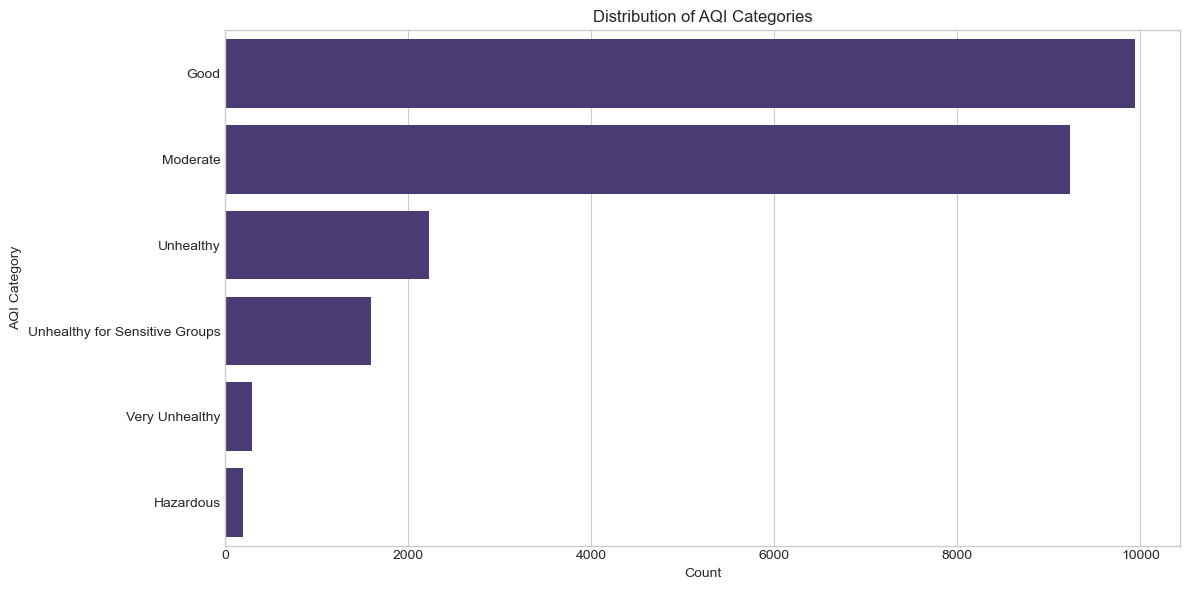

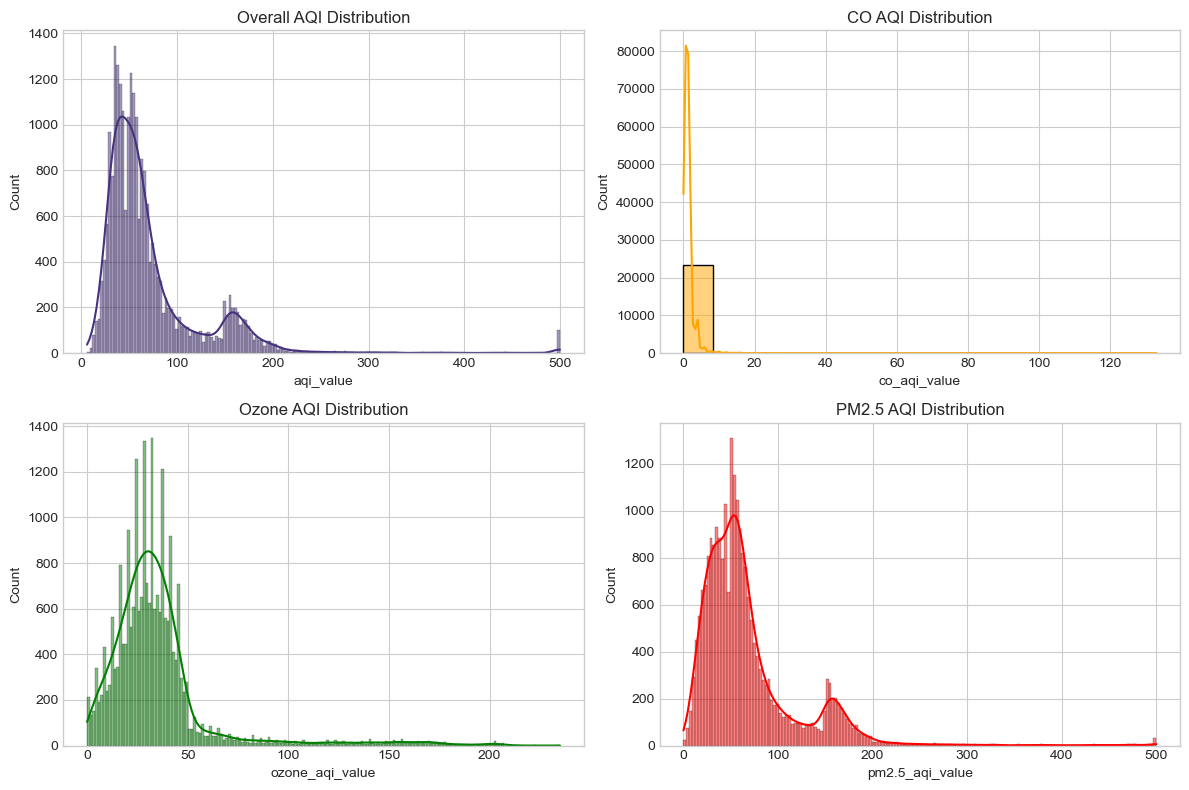

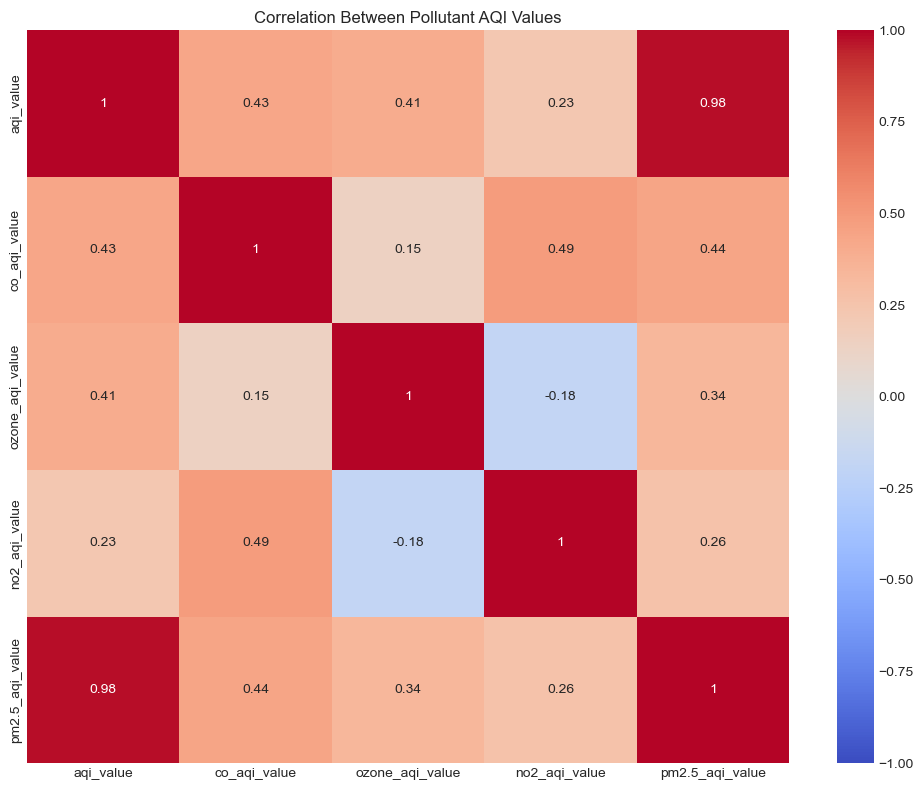

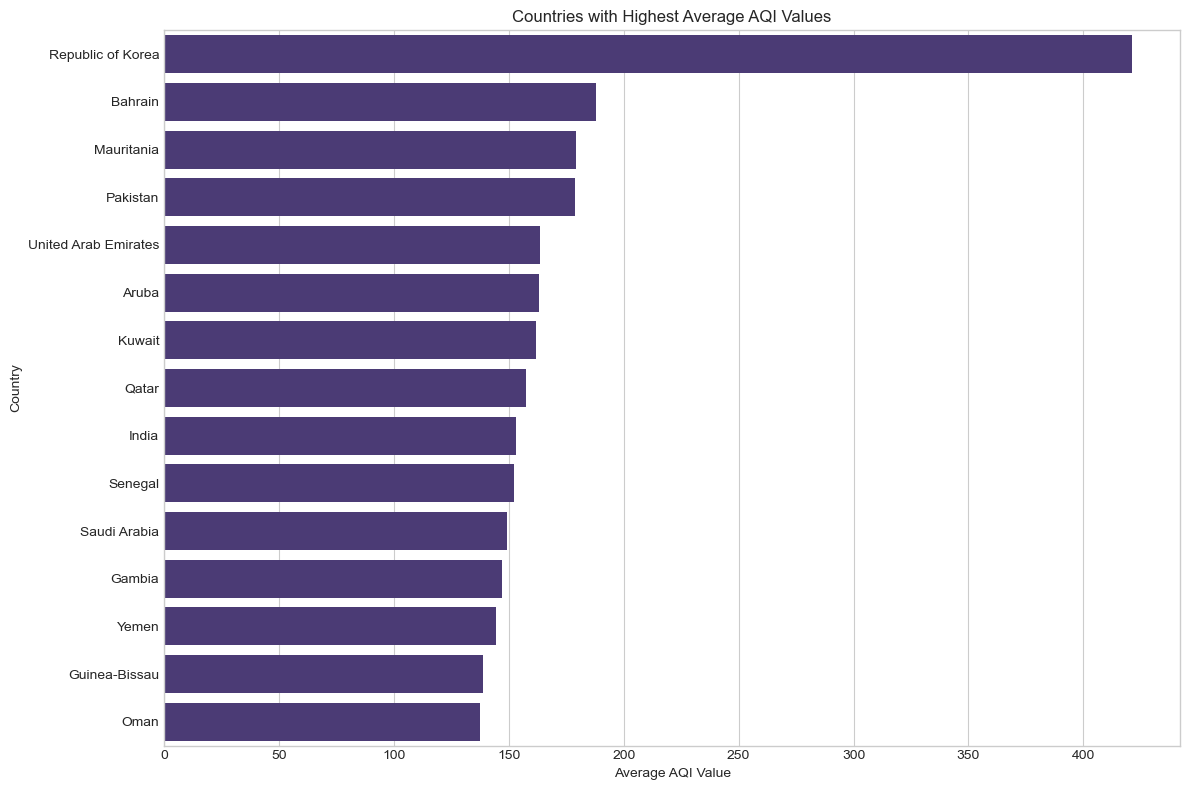

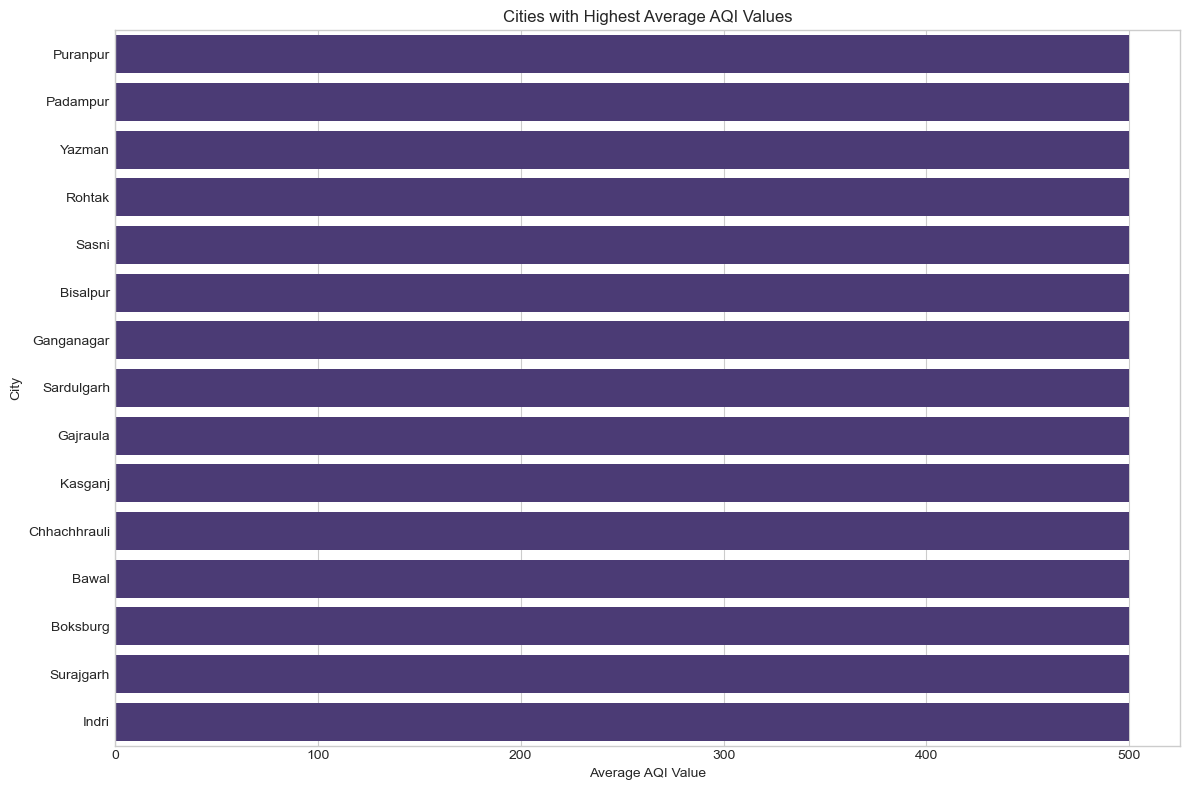

<Figure size 1600x1200 with 0 Axes>

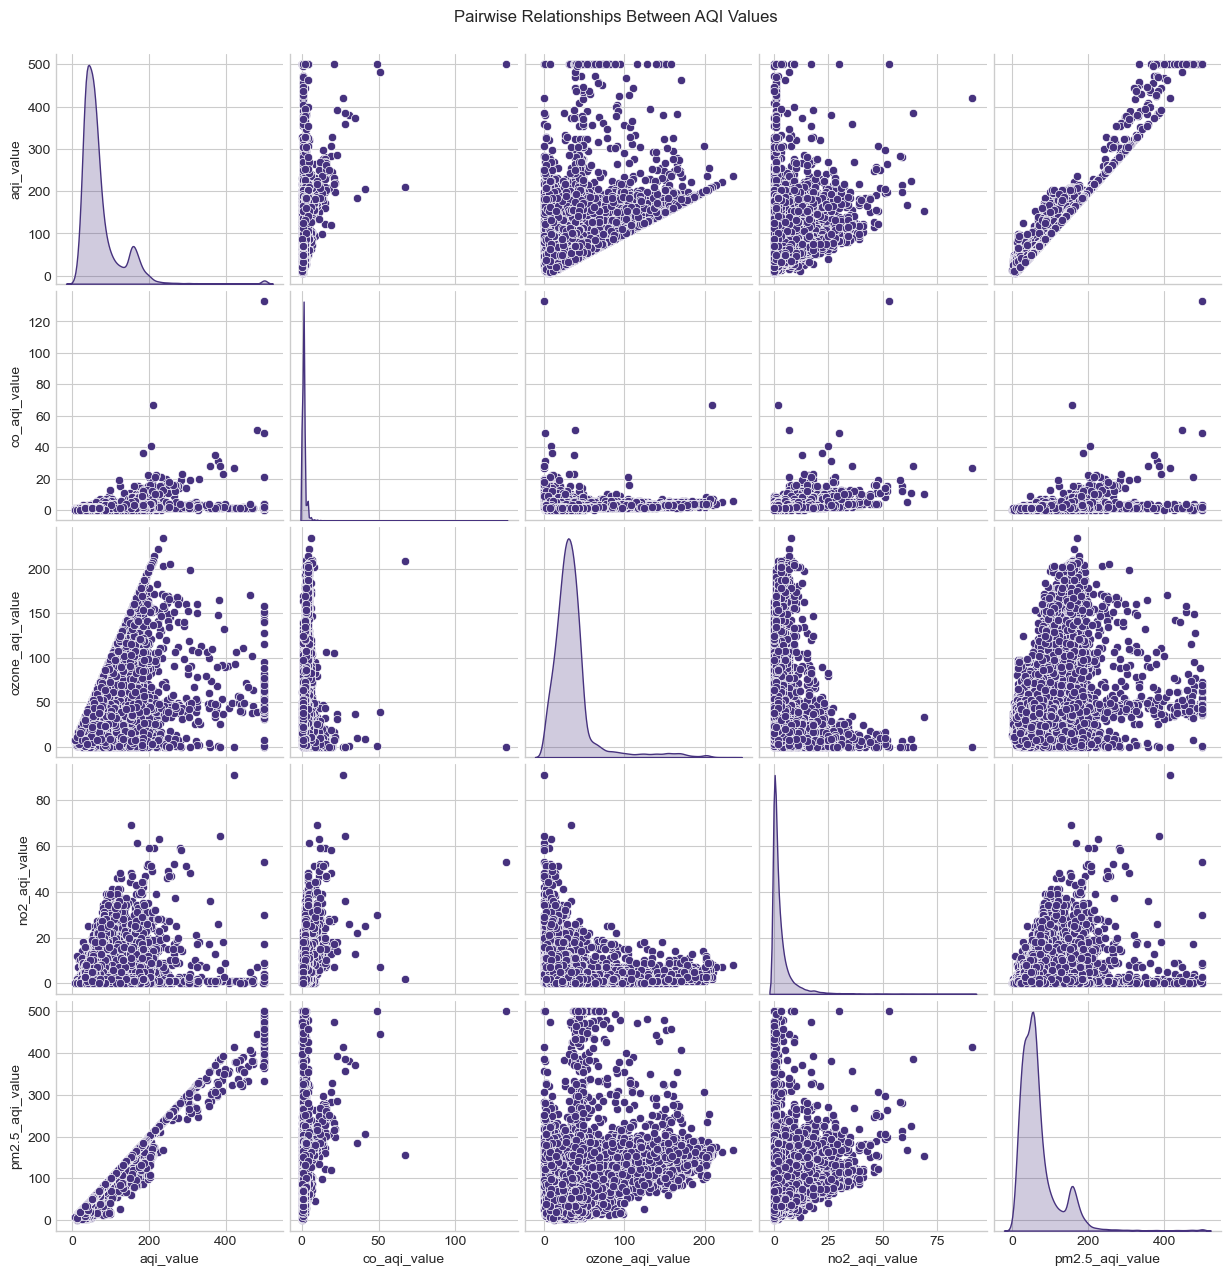

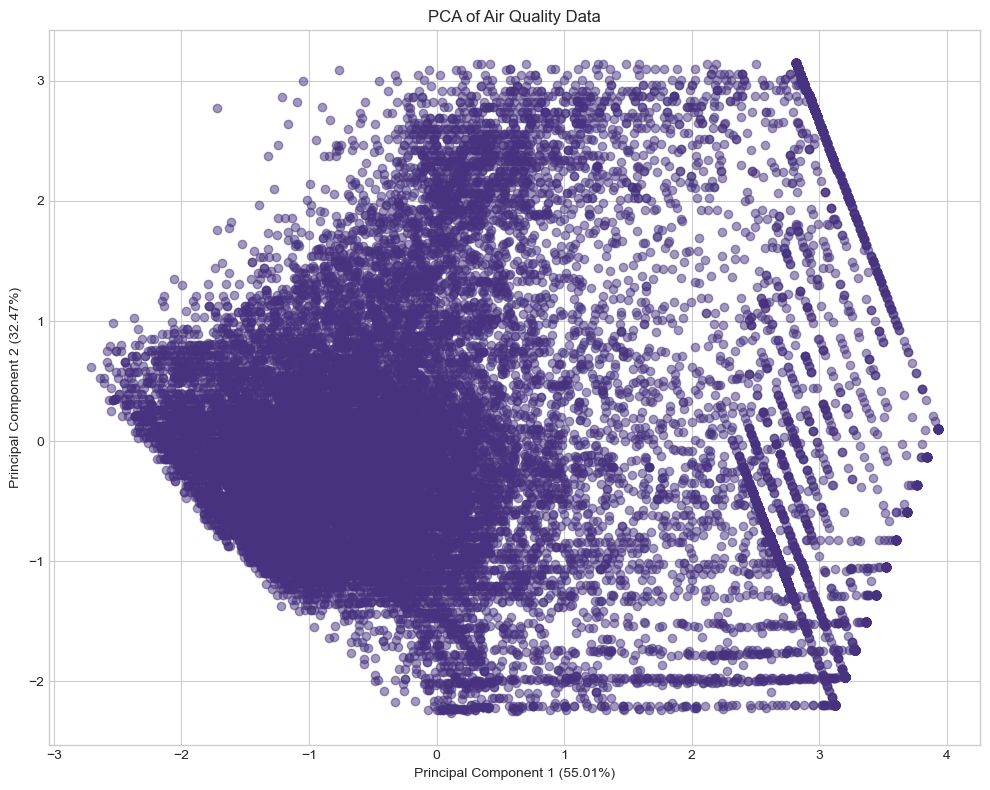

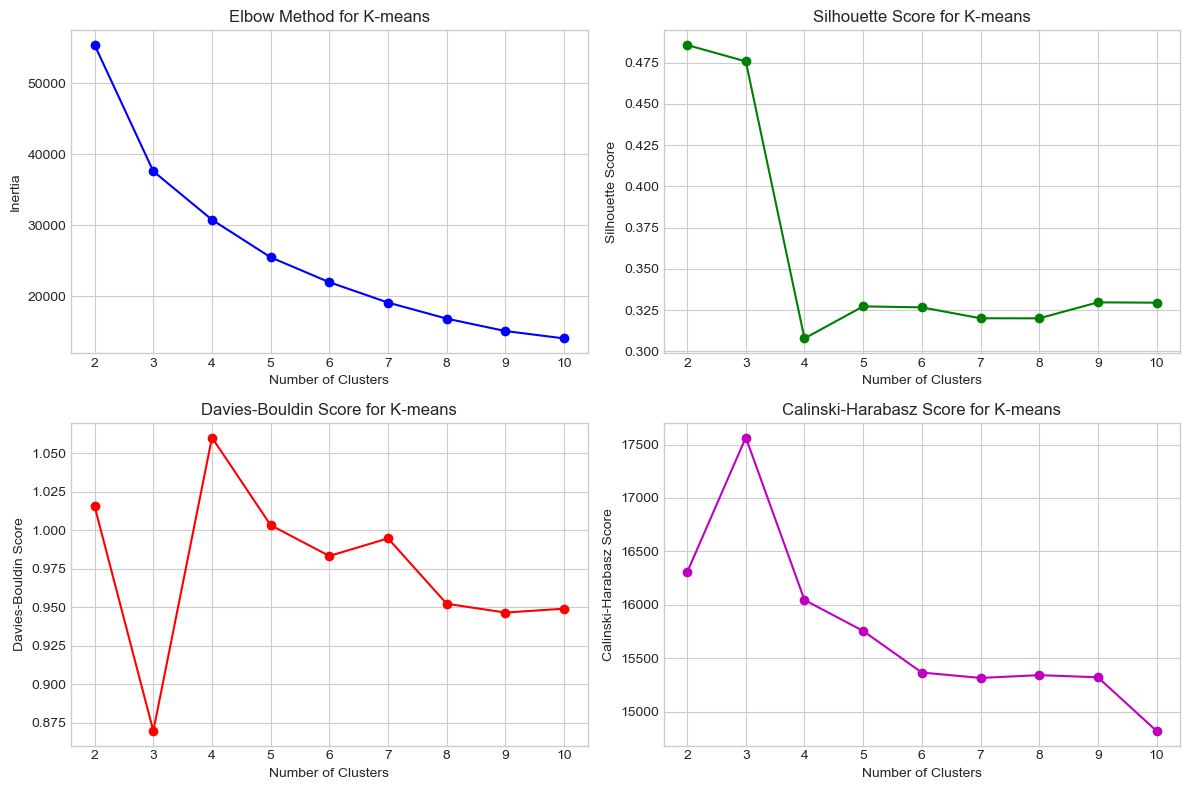

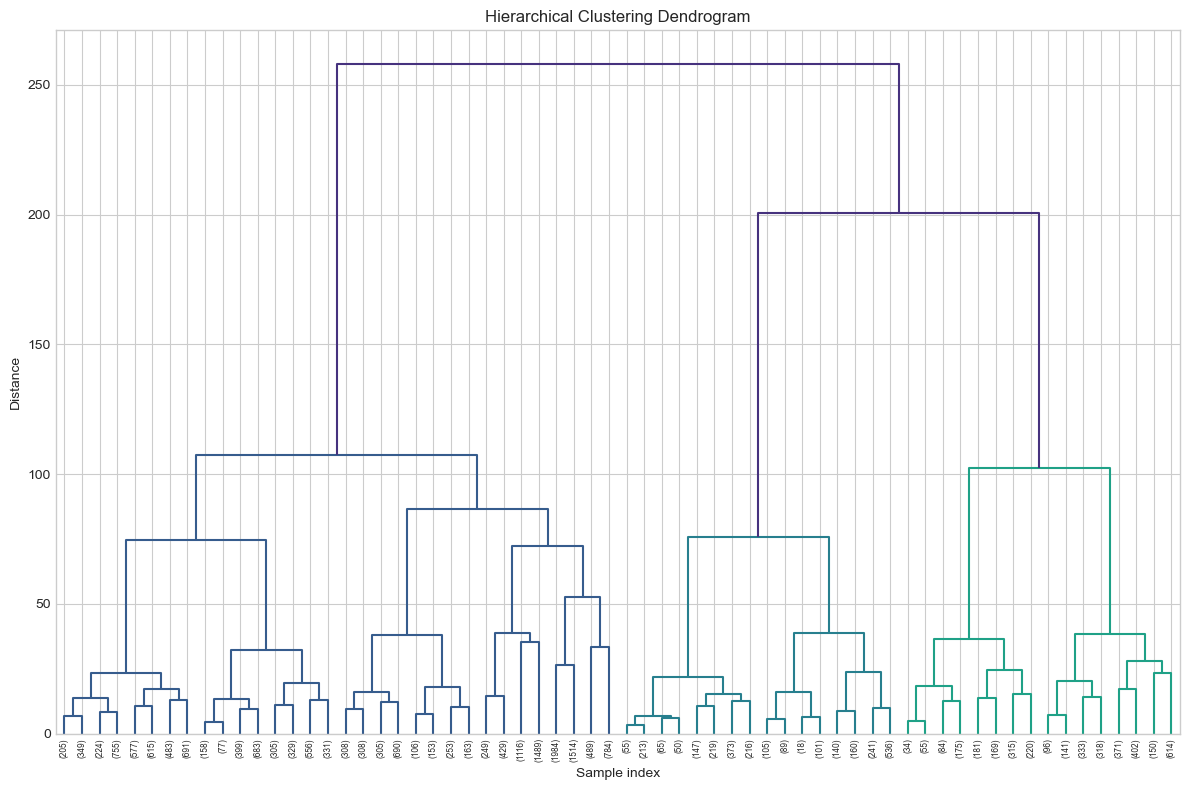

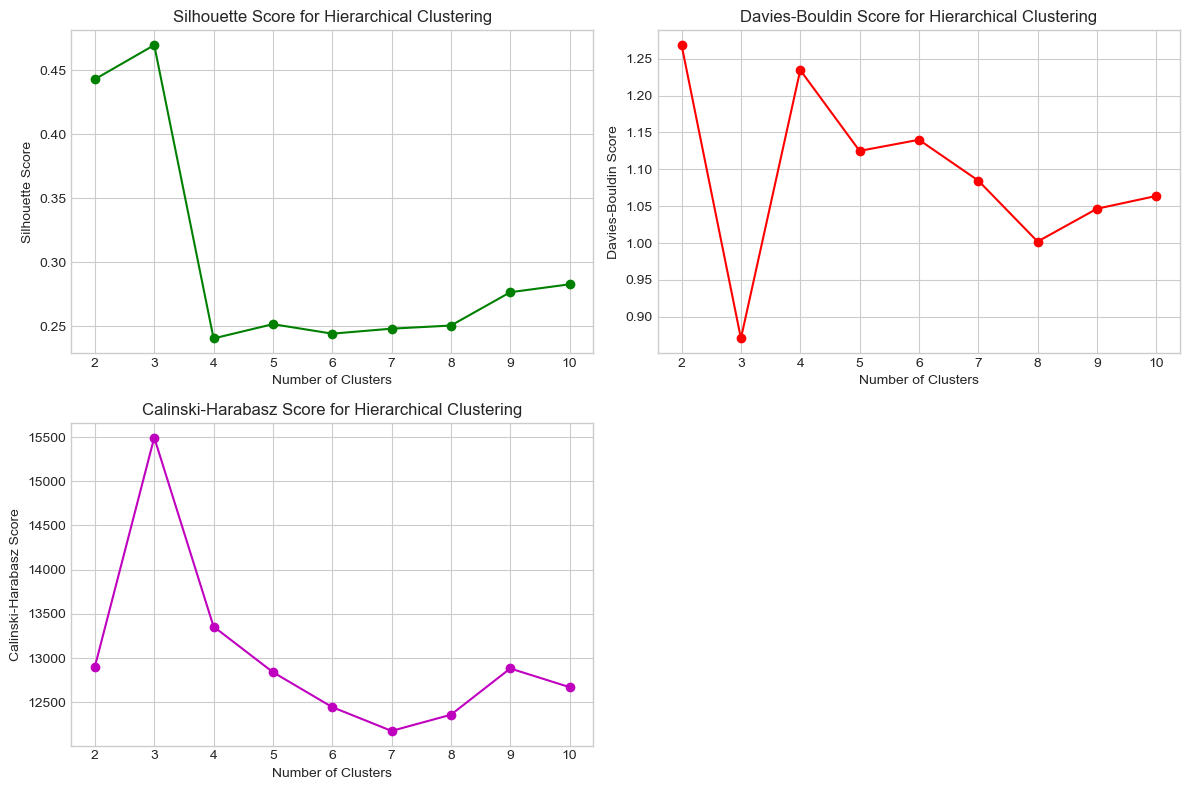

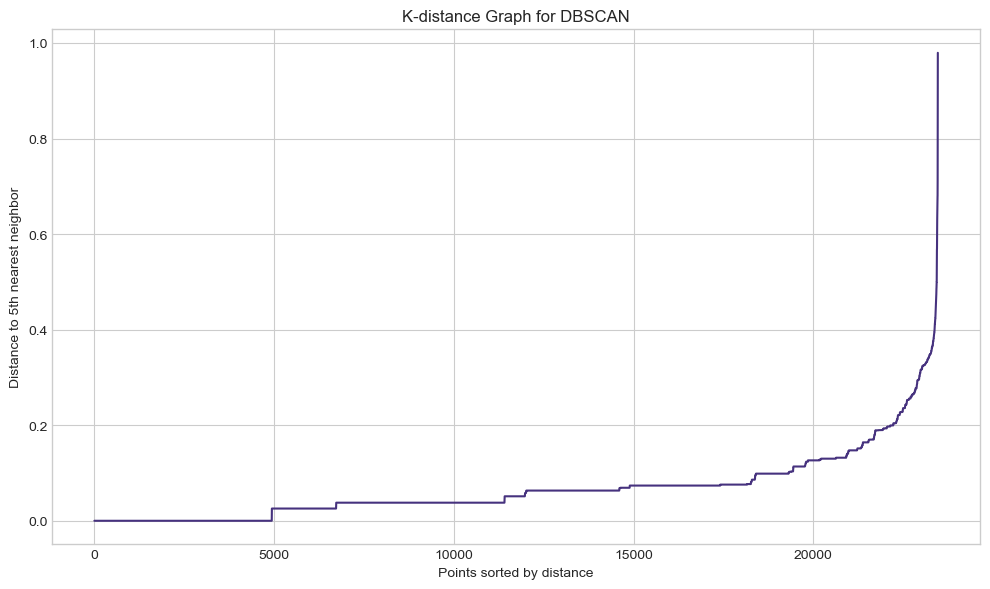

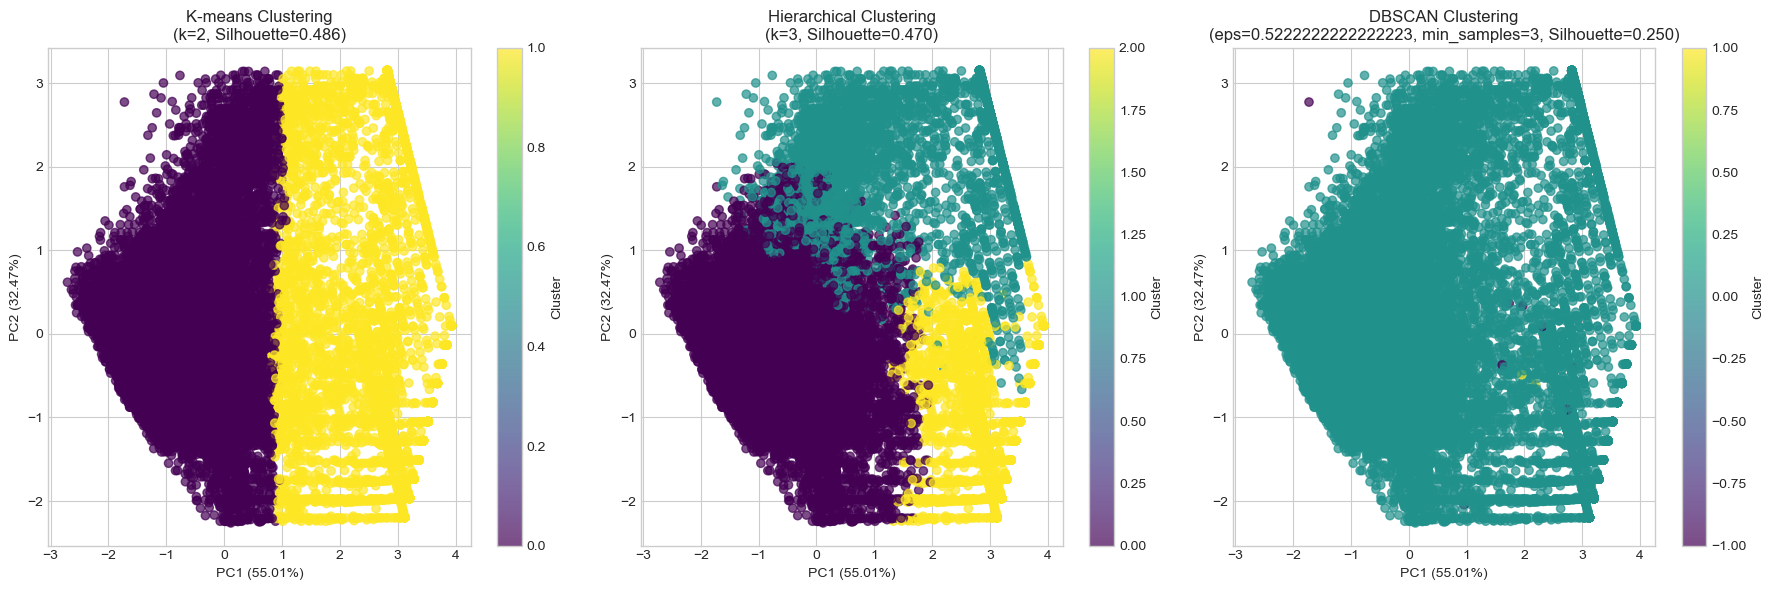

<Figure size 1400x800 with 0 Axes>

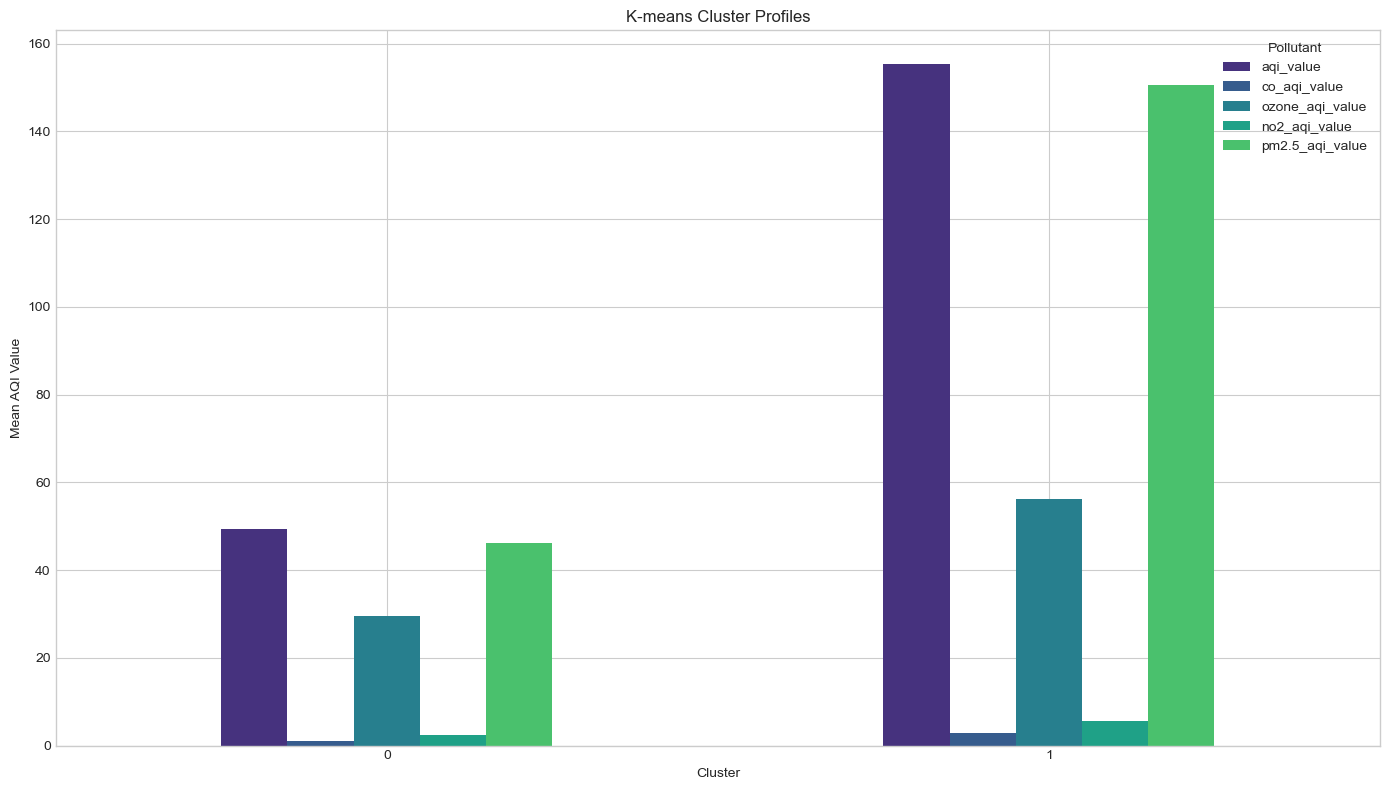

<Figure size 1400x800 with 0 Axes>

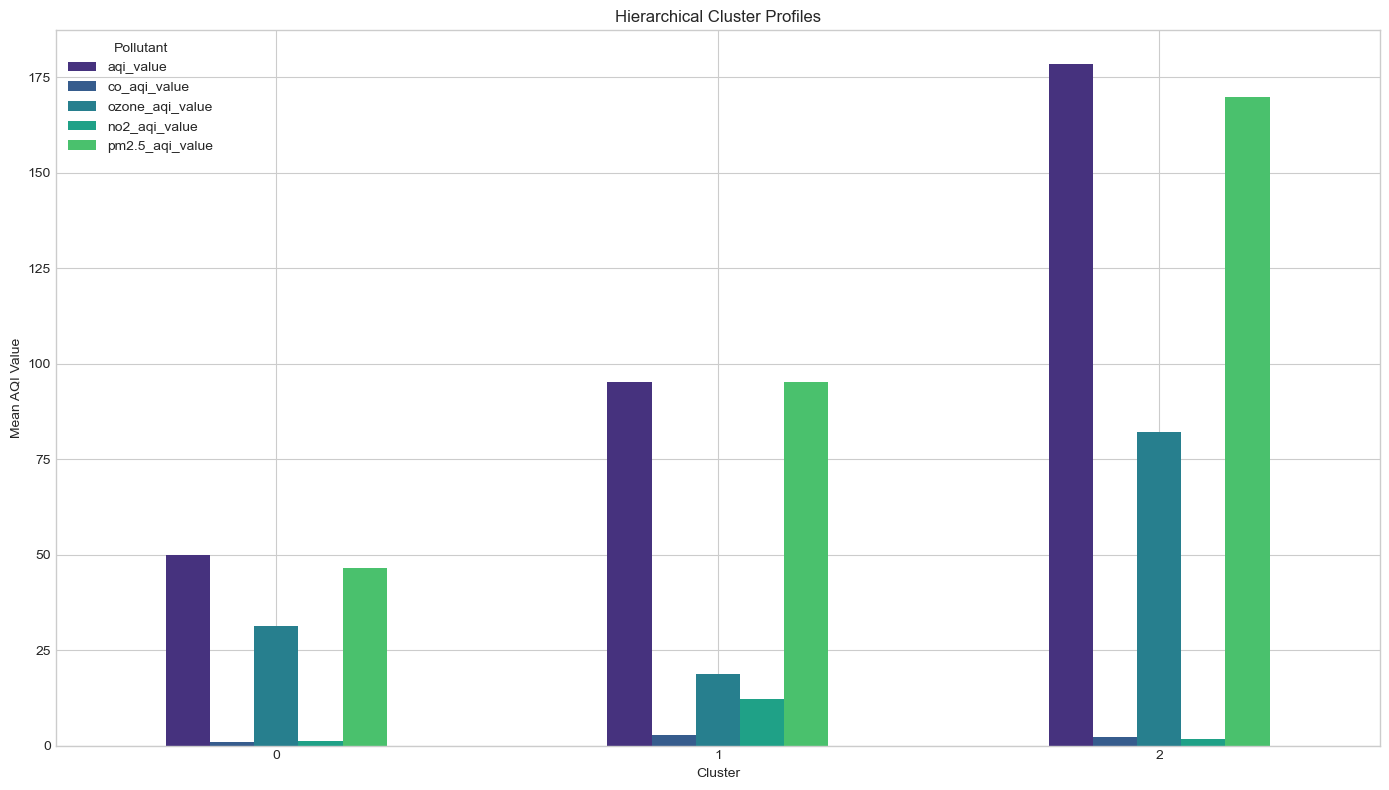

<Figure size 1400x800 with 0 Axes>

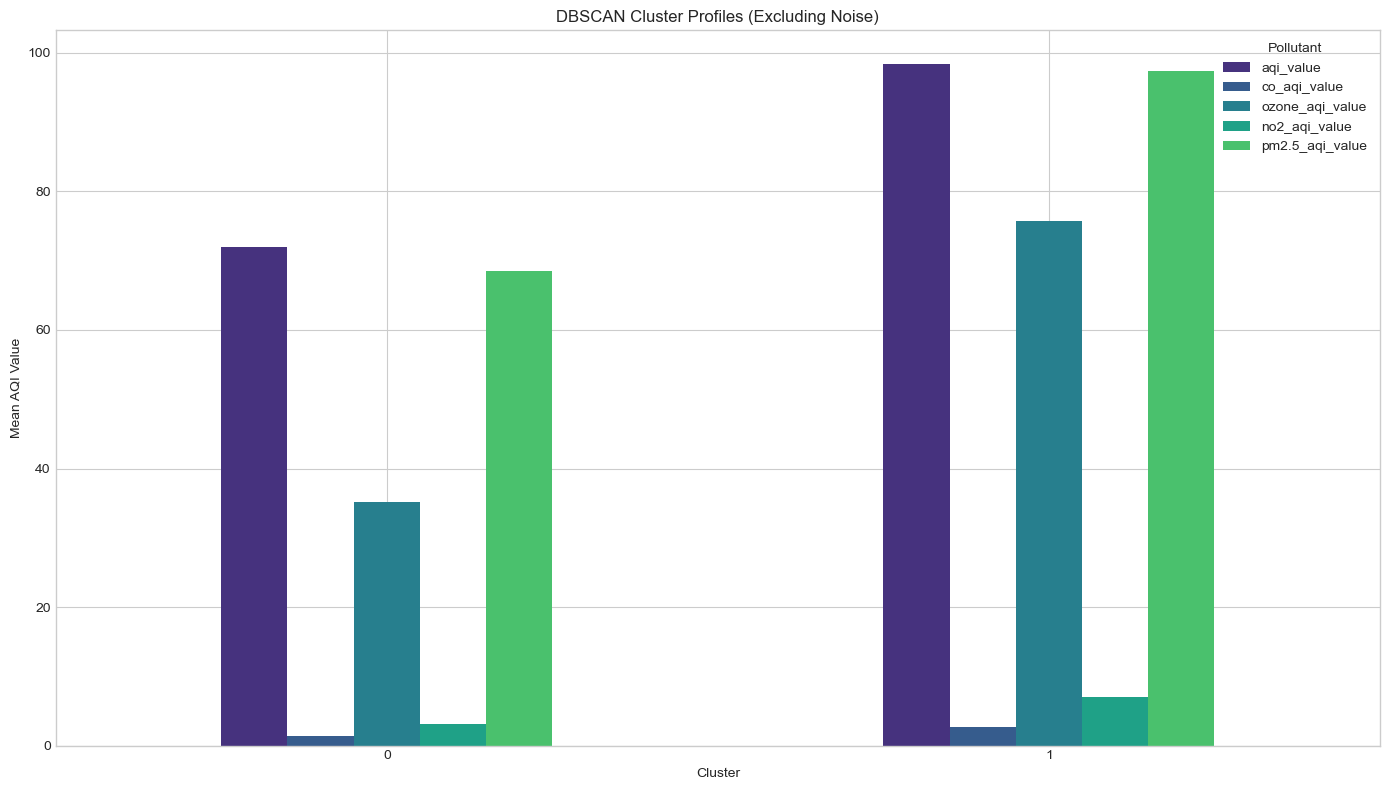

<Figure size 1200x800 with 0 Axes>

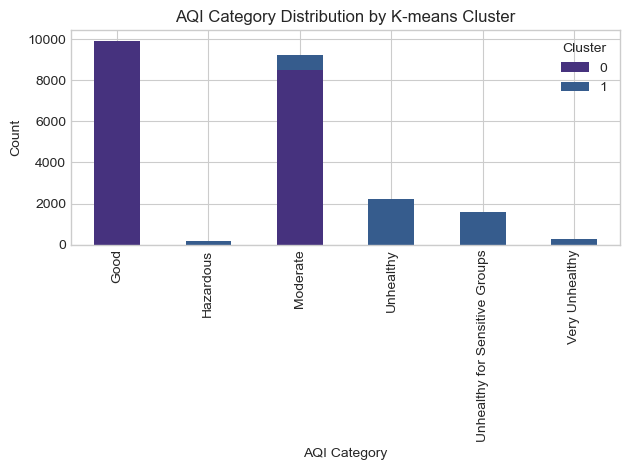

In [77]:
def main():
    """
    Main function to execute the air quality clustering analysis
    """
    print("===============================================")
    print("       AIR QUALITY CLUSTERING ANALYSIS         ")
    print("===============================================")
    
    # Load data
    df = load_data('global_air_pollution_data.csv')
    
    # Perform EDA
    df = perform_eda(df)
    
    # Preprocess data
    features_df, scaled_features = preprocess_data(df)
    
    # Apply K-means clustering
    kmeans_results = apply_kmeans(scaled_features)
    
    # Apply Hierarchical clustering
    hierarchical_results = apply_hierarchical_clustering(scaled_features)
    
    # Apply DBSCAN clustering
    dbscan_results = apply_dbscan(scaled_features)
    
    # Compare clustering methods
    df_with_clusters = compare_clustering_methods(
        features_df, 
        scaled_features, 
        kmeans_results, 
        hierarchical_results, 
        dbscan_results, 
        df
    )
    
    # Save the clustered data
    df_with_clusters.to_csv('air_quality_with_clusters.csv', index=False)
    print("\nClustered data saved to 'air_quality_with_clusters.csv'")
    
    # Report conclusions
    print("\n===============================================")
    print("               CONCLUSION                      ")
    print("===============================================")
    
    print("This analysis compared three clustering algorithms on global air quality data:")
    print("1. K-means")
    print("2. Hierarchical (Agglomerative) Clustering")
    print("3. DBSCAN")
    
    # Determine best algorithm based on silhouette score
    silhouette_scores = {
        'K-means': kmeans_results[1]['silhouette'],
        'Hierarchical': hierarchical_results[1]['silhouette'],
        'DBSCAN': dbscan_results[1]['silhouette']
    }
    
    best_algorithm = max(silhouette_scores, key=silhouette_scores.get)
    print(f"\nBased on silhouette score, the best performing algorithm is {best_algorithm}.")
    
    # Additional conclusions based on best algorithm
    if best_algorithm == 'K-means':
        optimal_k = kmeans_results[1]['n_clusters']
        print(f"The optimal number of clusters is {optimal_k}.")
        
        # Get cluster profiles for K-means
        cluster_profiles = df_with_clusters.groupby('kmeans_cluster').agg({
            'aqi_value': 'mean',
            'co_aqi_value': 'mean',
            'ozone_aqi_value': 'mean',
            'no2_aqi_value': 'mean',
            'pm2.5_aqi_value': 'mean'
        }).round(2)
        
        # Identify key characteristics of each cluster
        for cluster in range(optimal_k):
            profile = cluster_profiles.loc[cluster]
            print(f"\nCluster {cluster} characteristics:")
            print(f"  - Overall AQI: {profile['aqi_value']}")
            print(f"  - CO AQI: {profile['co_aqi_value']}")
            print(f"  - Ozone AQI: {profile['ozone_aqi_value']}")
            print(f"  - NO2 AQI: {profile['no2_aqi_value']}")
            print(f"  - PM2.5 AQI: {profile['pm2.5_aqi_value']}")
            
            # Identify primary pollutant
            pollutants = ['co_aqi_value', 'ozone_aqi_value', 'no2_aqi_value', 'pm2.5_aqi_value']
            primary_pollutant = pollutants[np.argmax([profile[p] for p in pollutants])]
            primary_pollutant = primary_pollutant.split('_')[0].upper()
            print(f"  - Primary pollutant: {primary_pollutant}")
            
            # Get top countries in this cluster
            top_countries = df_with_clusters[df_with_clusters['kmeans_cluster'] == cluster]['country_name'].value_counts().head(3)
            top_countries_str = ', '.join(top_countries.index)
            print(f"  - Top countries: {top_countries_str}")
            
            # Get most common AQI category
            top_category = df_with_clusters[df_with_clusters['kmeans_cluster'] == cluster]['aqi_category'].value_counts().index[0]
            print(f"  - Most common AQI category: {top_category}")
    
    print("\nFurther analysis of the clustering results can provide insights into:")
    print("1. Regional patterns of air pollution")
    print("2. Relationships between different pollutants")
    print("3. Identification of cities with similar air quality profiles")
    print("4. Seasonal variations in air quality (if time data is available)")
    
    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()